# ML with data obtained by parsing the IUPAC names predicting TDP1 inhibitors. PCA reduced features. 

### Content   <a name="content"></a>

1. [Load data](#1)
2. [Ensure equal number of target 1 and 0 in the test data](#2)
3. [Balance data](#3)
4. [PCA](#4)
5. [ML](#5)


### Load data <a name="1"></a>

In [1]:
import pandas as pd 

# loading the dataset for ML
df = pd.read_csv('data_IUPACs_II.csv', index_col=[0])

# Display the data frame
print('Shape of df: ', df.shape)
df.head()

Shape of df:  (101860, 5963)


,target,acenaphthylene,acenaphthyleno,acetaldehyde,acetamide,acetamido,acetamidoacetyl,acetamidoadamantane,acetamidoanilino,acetamidobenzenesulfonate,...,ynylquinolin,ynylspiro,ynylsulfanyl,ynylsulfanylpyridine,ynylsulfanylpyrido,ynylsulfanylpyrimidin,ynylsulfanyltetrazole,ynylthieno,yohimban,zinc
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[<a href="#content">Back to top</a>]

## Ensure equal number of target 1 and 0 in the testing set <a name="2"></a>

In [2]:
# from 140,213 samples  
df['target'].value_counts()

target
1    61456
0    40404
Name: count, dtype: int64

In [3]:
# Handle the part of target 0 in the test set 
df_0 = df[df['target']==0]

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract 1650 samples (10% of 16,419 samples) of target 0 for the test set Extract 10% of target 1 for the test set
df_0_test = df_0.iloc[:14100]

# Assign the rest of target 1 for the train set
df_0_train = df_0.iloc[14100:]

In [4]:
# Handle the part of target 1 in the test set 
df_1 = df[df['target']==1]

# Shuffle the resulting data set
df_1 = df_1.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract 2800 samples (10% of 28000 samples) of target 1 for the test set
df_1_test = df_1.iloc[:14100]

# Assign the rest of target 1 for the train set
df_1_train = df_1.iloc[14100:]

In [5]:
# Create train and test dataframes for further manipulation 
train = pd.concat([df_0_train, df_1_train])
test = pd.concat([df_0_test, df_1_test])

In [6]:
# Shuffle the resulting data sets
train = train.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Shuffle the resulting data set
test = test.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

In [7]:
# Create the sets for ML 
X_train = train.drop(columns='target', axis=1)
y_train = train['target']
X_test =  test.drop(columns='target', axis=1)
y_test = test['target']

In [8]:
# Create the sets for Cross-validation
X = pd.concat([X_train, X_test])
y = pd.concat([y_train,y_test])

In [9]:
# Check the number of classes in the y_test set
y_test.value_counts()

target
1    14100
0    14100
Name: count, dtype: int64

[<a href="#content">Back to top</a>]

## Balance data  <a name="3"></a>

[(0, 26304), (1, 47356)]


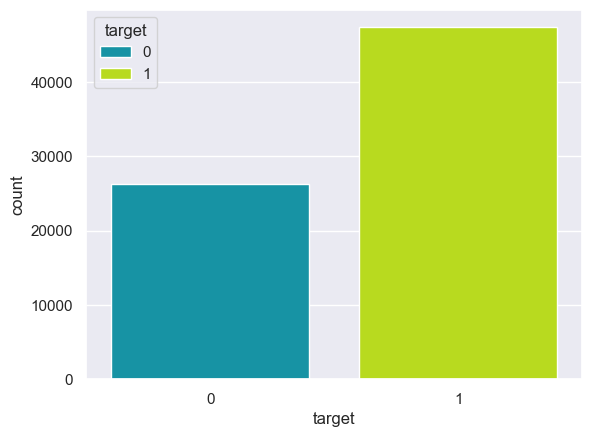

In [10]:
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

# Illustrate the imbalance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train, palette='nipy_spectral')
plt.show()

[(0, 47356), (1, 47356)]


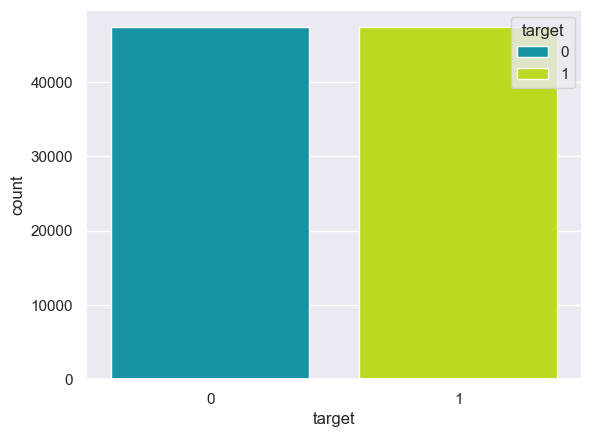

In [11]:
from imblearn.over_sampling import RandomOverSampler

# Balance targets with RandomOverSampler
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

# Illustrate the balance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train,palette='nipy_spectral')
plt.show()

[<a href="#content">Back to top</a>]

## PCA  <a name="4"></a>

In [12]:
import numpy as np

# Determine the number of the PCA components
# Scale the data points
# X_pca = sc.fit_transform(X_train)

# Mean
X_mean = X_train.mean()

# Standard deviation
X_std = X.std()

# Standardization
Z = (X - X_mean) / X_std

# covariance
c = X.cov()

# Handle infinite values
c.replace([np.inf, -np.inf], np.nan, inplace=True)
c.fillna(c.mean(), inplace=True)

eigenvalues, eigenvectors = np.linalg.eig(c)

# Index the eigenvalues in descending order 
idx = eigenvalues.argsort()[::-1]

# Sort the eigenvalues in descending order 
eigenvalues = eigenvalues[idx]

# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]

explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)

n_components = np.argmax(explained_var >= 0.50) + 1
n_components

45

In [13]:
from sklearn.decomposition import PCA

# Fit PCA on the training set
pca = PCA(n_components=45)  # Adjust n_components as needed
pca.fit(X_train)

# Transform both training and test sets
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (94712, 45)
X_test:   (28200, 45)
y_train:  (94712,)
y_test:   (28200,)


[<a href="#content">Back to top</a>]

## ML  <a name="5"></a>

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Instantiate the estimator 
model = RandomForestClassifier()

# Train  
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.697
Precision:  0.658
Recall:  0.821
F1:  0.73
ROC:  0.697


[<a href="#content">Back to top</a>]